In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

import scipy as sp
import xgboost as xgb

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error


import datetime as dt

In [2]:
df = pd.read_csv('data/Microsoft_Stock.csv', parse_dates=['Date'])

In [3]:
df.head(5)

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1511 non-null   datetime64[ns]
 1   Open    1511 non-null   float64       
 2   High    1511 non-null   float64       
 3   Low     1511 non-null   float64       
 4   Close   1511 non-null   float64       
 5   Volume  1511 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 71.0 KB


In [5]:
df.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


In [6]:
print(df.Date.min())
print(df.Date.max())

2015-04-01 16:00:00
2021-03-31 16:00:00


In [7]:
time_data = df[['Date', 'Close']].set_index('Date')

#monthly data - maybe for more basic analysis
m_data = time_data.resample('M').mean()

In [8]:
display(time_data)
print(time_data.shape)

,Close
Date,
2015-04-01 16:00:00,40.72
2015-04-02 16:00:00,40.29
2015-04-06 16:00:00,41.55
2015-04-07 16:00:00,41.53
2015-04-08 16:00:00,41.42
...,...
2021-03-25 16:00:00,232.34
2021-03-26 16:00:00,236.48
2021-03-29 16:00:00,235.24


(1511, 1)


Text(0.5, 1.0, 'MS closing stock price')

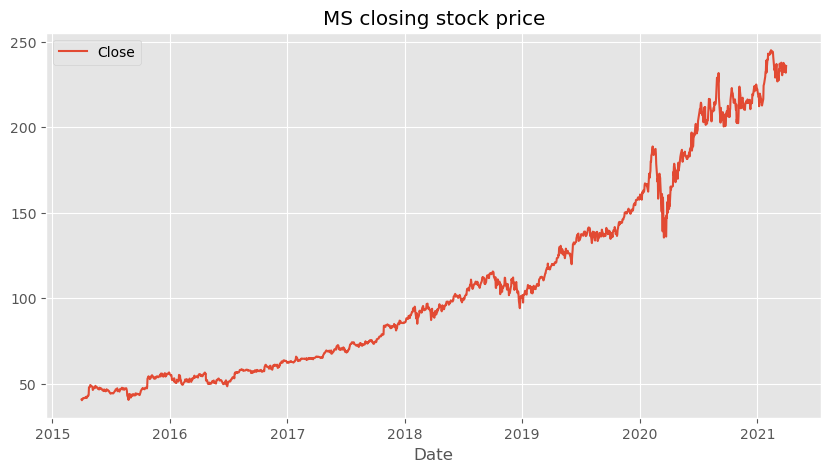

In [9]:
plt.figure(figsize=(10,5))
sns.lineplot(time_data)
plt.title('MS closing stock price')

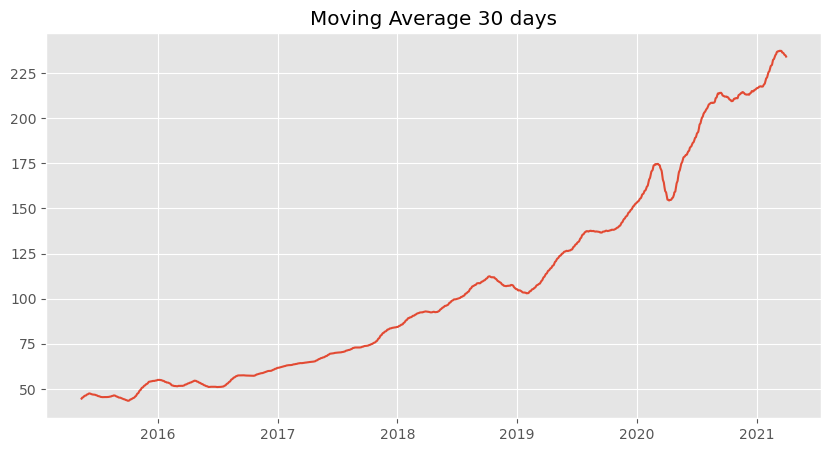

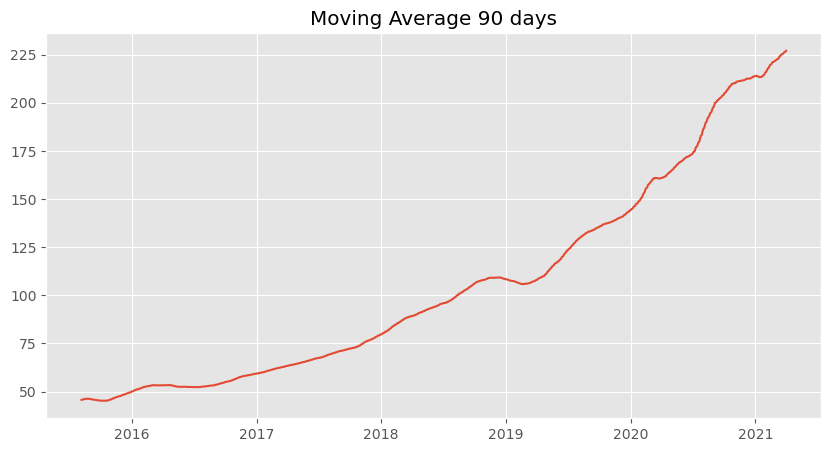

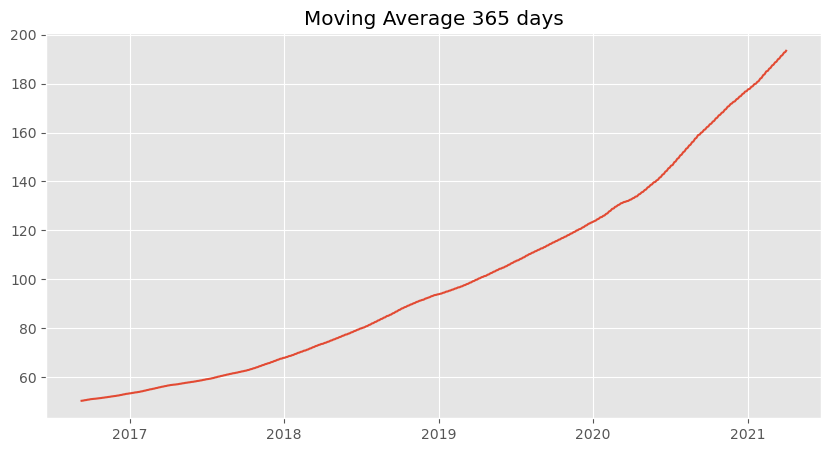

In [10]:
#Moving averages month -qtr - year
for i in [30, 90, 365]:
    plt.figure(figsize=(10,5))
    plt.plot(time_data.rolling(i).mean())
    plt.title('Moving Average {} days'.format(i))
    plt.plot()

[]

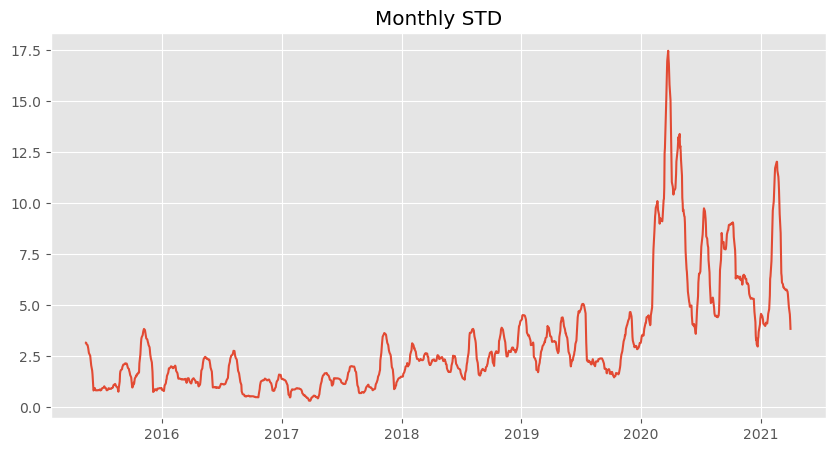

In [11]:
# Monthly std

plt.figure(figsize=(10,5))
plt.plot(time_data.rolling(30).std())
plt.title('Monthly STD')
plt.plot()

In [12]:
adf_result = adfuller(time_data, autolag='AIC')


print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"  {key}: {value}")

Augmented Dickey-Fuller Test Results:
ADF Statistic: 1.7371362899270972
P-value: 0.9982158366942122
Critical Values:
  1%: -3.4347582315402434
  5%: -2.863486949792871
  10%: -2.567806534528638


In [13]:
#defining stationarity function

def test_stationarity(data):
    """
    function for checking the stationarity of the time series dataset
    """
    # Determing rolling statistics
    rolmean = data.rolling(12).mean() # rolling mean
    rolstd = data.rolling(12).std() # rolling standard deviation
    # Plot rolling statistics:
    plt.figure(figsize = (18,10))
    plt.grid('both')
    plt.plot(data, color='blue',label='Original', linewidth = 3)
    plt.plot(rolmean, color='red', label='Rolling Mean',linewidth = 3)
    plt.plot(rolstd, color='black', label = 'Rolling Std',linewidth = 4)
    plt.legend(loc='best', fontsize = 20, shadow=True,facecolor='lightpink',edgecolor = 'k')
    plt.title('Rolling Mean and Standard Deviation', fontsize = 25)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show(block=False)
    
    print("Results of dickey fuller test :")
    adft = adfuller(data,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

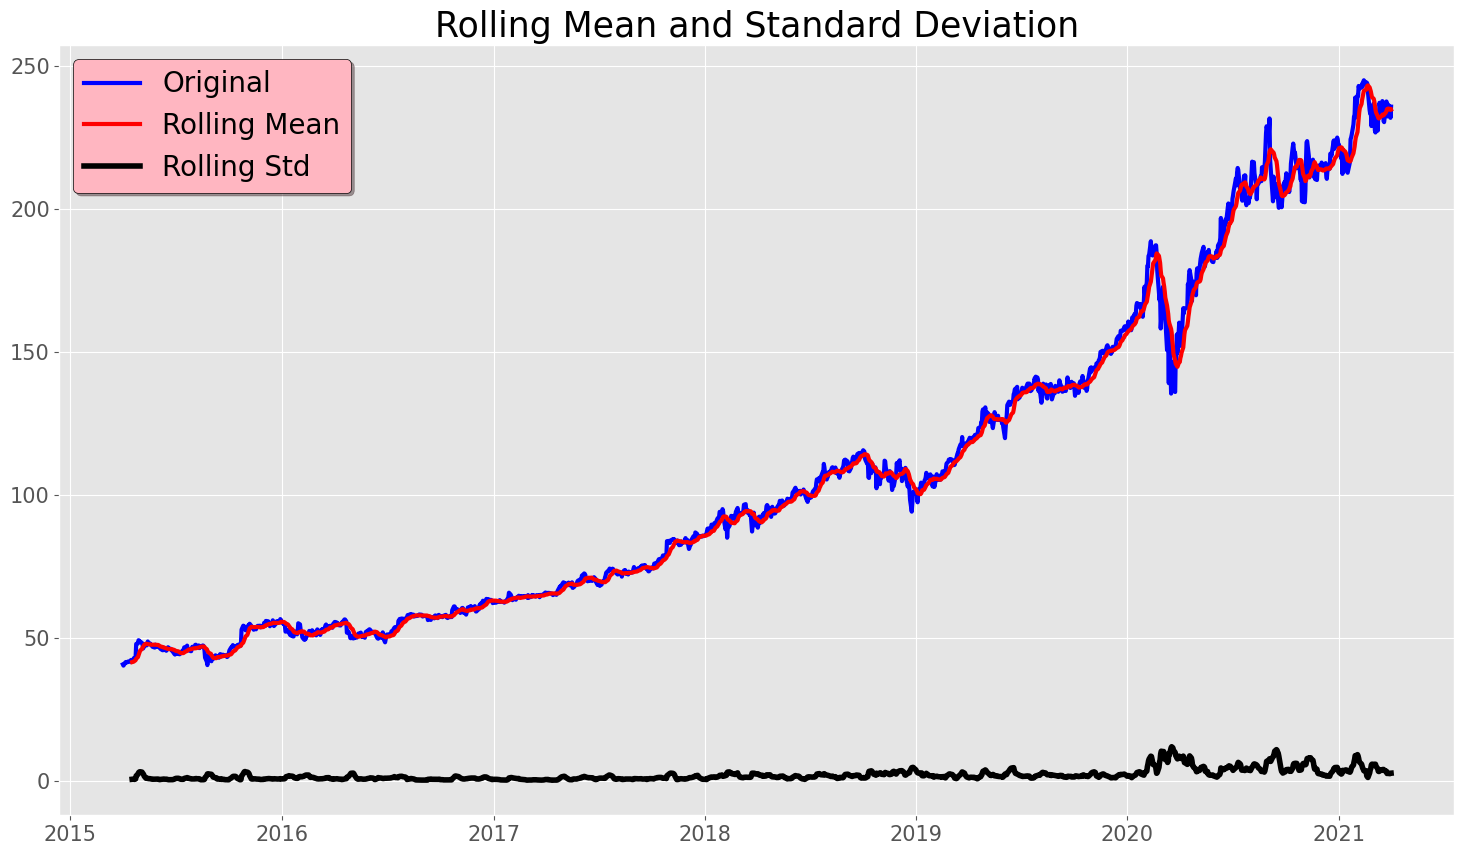

Results of dickey fuller test :
Test Statistics                   1.737136
p-value                           0.998216
No. of lags used                 24.000000
Number of observations used    1486.000000
critical value (1%)              -3.434758
critical value (5%)              -2.863487
critical value (10%)             -2.567807
dtype: float64


In [14]:
test_stationarity(time_data)

In [15]:
# converting to stationary data

data_stat = time_data.diff().dropna()

data_stat.head()

,Close
Date,
2015-04-02 16:00:00,-0.43
2015-04-06 16:00:00,1.26
2015-04-07 16:00:00,-0.02
2015-04-08 16:00:00,-0.11
2015-04-09 16:00:00,0.06


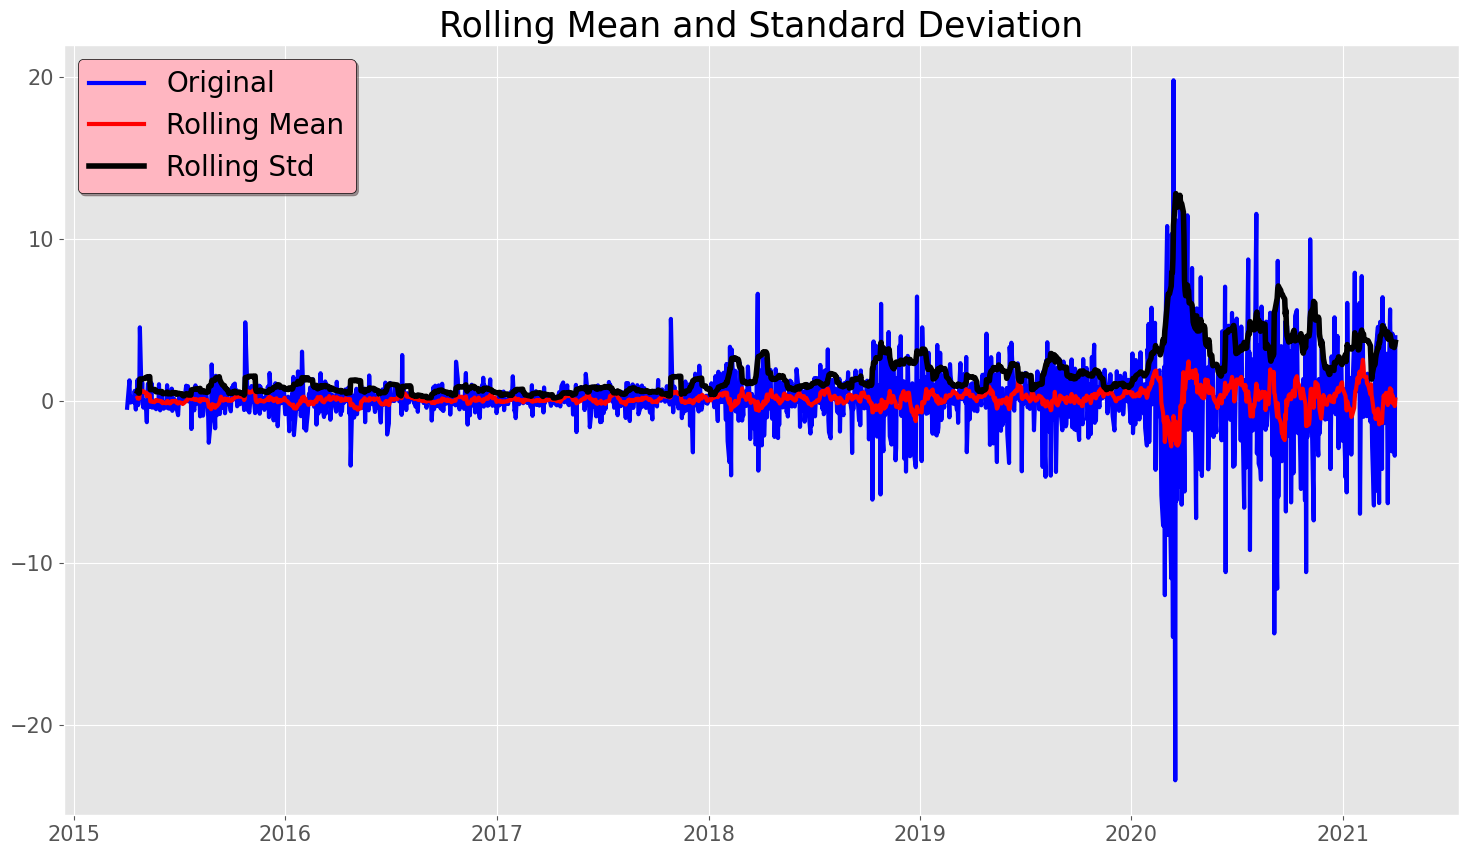

Results of dickey fuller test :
Test Statistics               -1.003833e+01
p-value                        1.519594e-17
No. of lags used               2.400000e+01
Number of observations used    1.485000e+03
critical value (1%)           -3.434761e+00
critical value (5%)           -2.863488e+00
critical value (10%)          -2.567807e+00
dtype: float64


In [16]:
test_stationarity(data_stat)

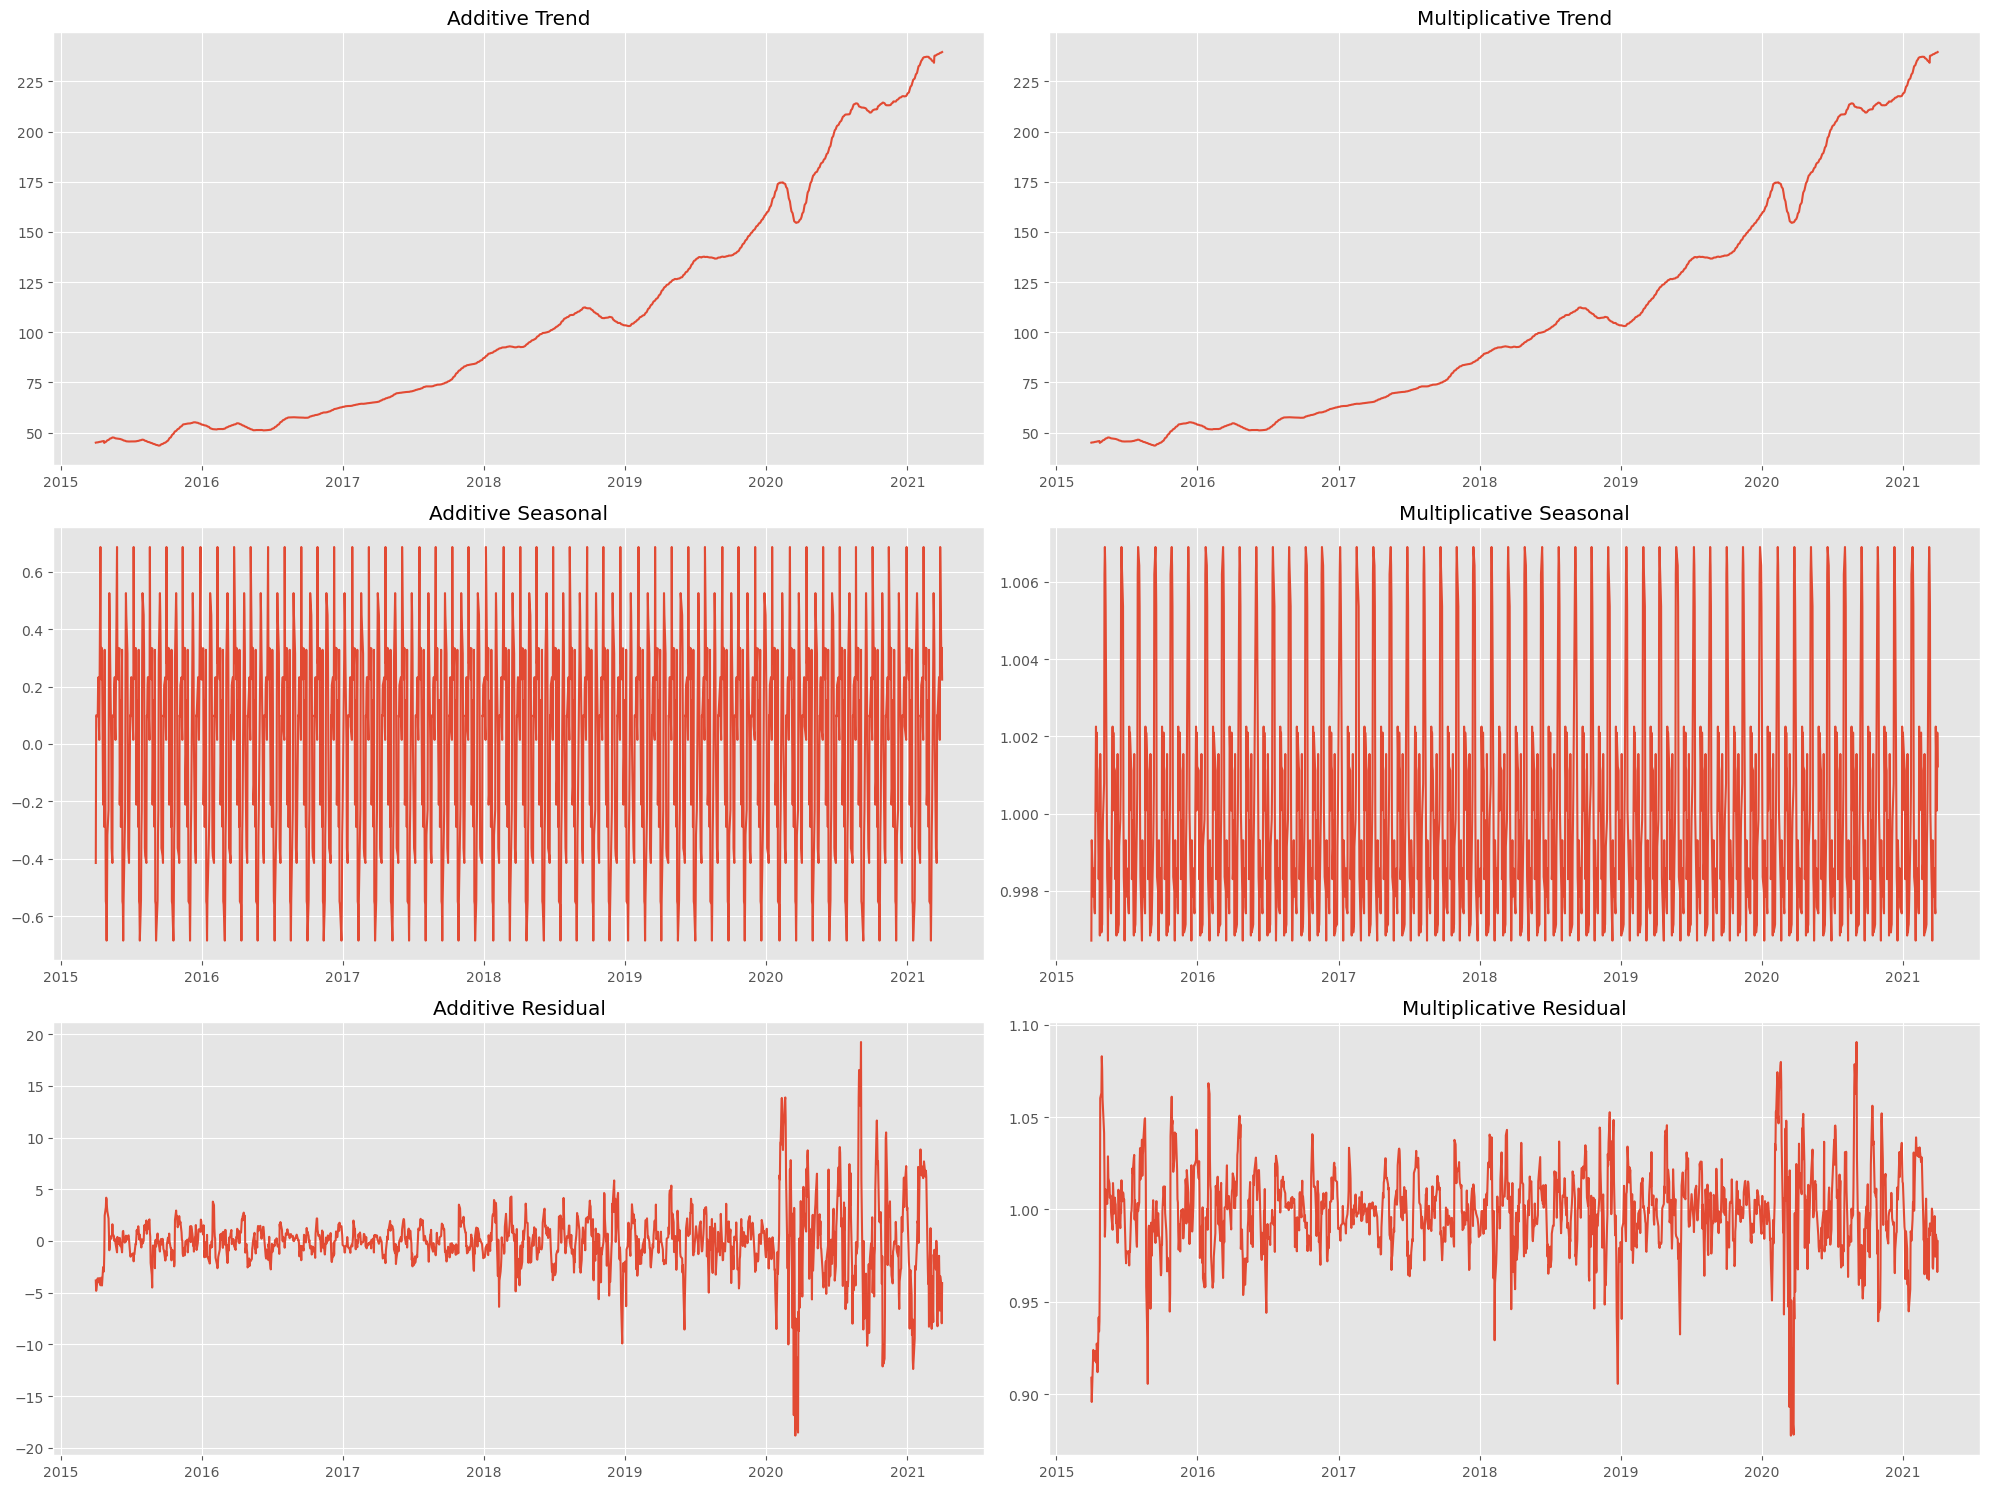

In [17]:
# Trend, Seasonality and residual - monthly

# Decompose time_data with additive model
result_additive = seasonal_decompose(time_data, model='additive', extrapolate_trend='freq', period=30)

# Decompose time_data with multiplicative model
result_multiplicative = seasonal_decompose(time_data, model='multiplicative', extrapolate_trend='freq', period=30)

# Plot
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

# Plot for additive decomposition
axes[0, 0].plot(result_additive.trend)
axes[0, 0].set_title('Additive Trend')

axes[1, 0].plot(result_additive.seasonal)
axes[1, 0].set_title('Additive Seasonal')

axes[2, 0].plot(result_additive.resid)
axes[2, 0].set_title('Additive Residual')

# Plot for multiplicative decomposition
axes[0, 1].plot(result_multiplicative.trend)
axes[0, 1].set_title('Multiplicative Trend')

axes[1, 1].plot(result_multiplicative.seasonal)
axes[1, 1].set_title('Multiplicative Seasonal')

axes[2, 1].plot(result_multiplicative.resid)
axes[2, 1].set_title('Multiplicative Residual')

plt.tight_layout()

# Train Test split

In [18]:
split_until = round(len(time_data) * 0.8)

train_data = time_data.iloc[:split_until]
test_data = time_data.iloc[split_until:]

train_data.shape[0]+test_data.shape[0] == time_data.shape[0]

True

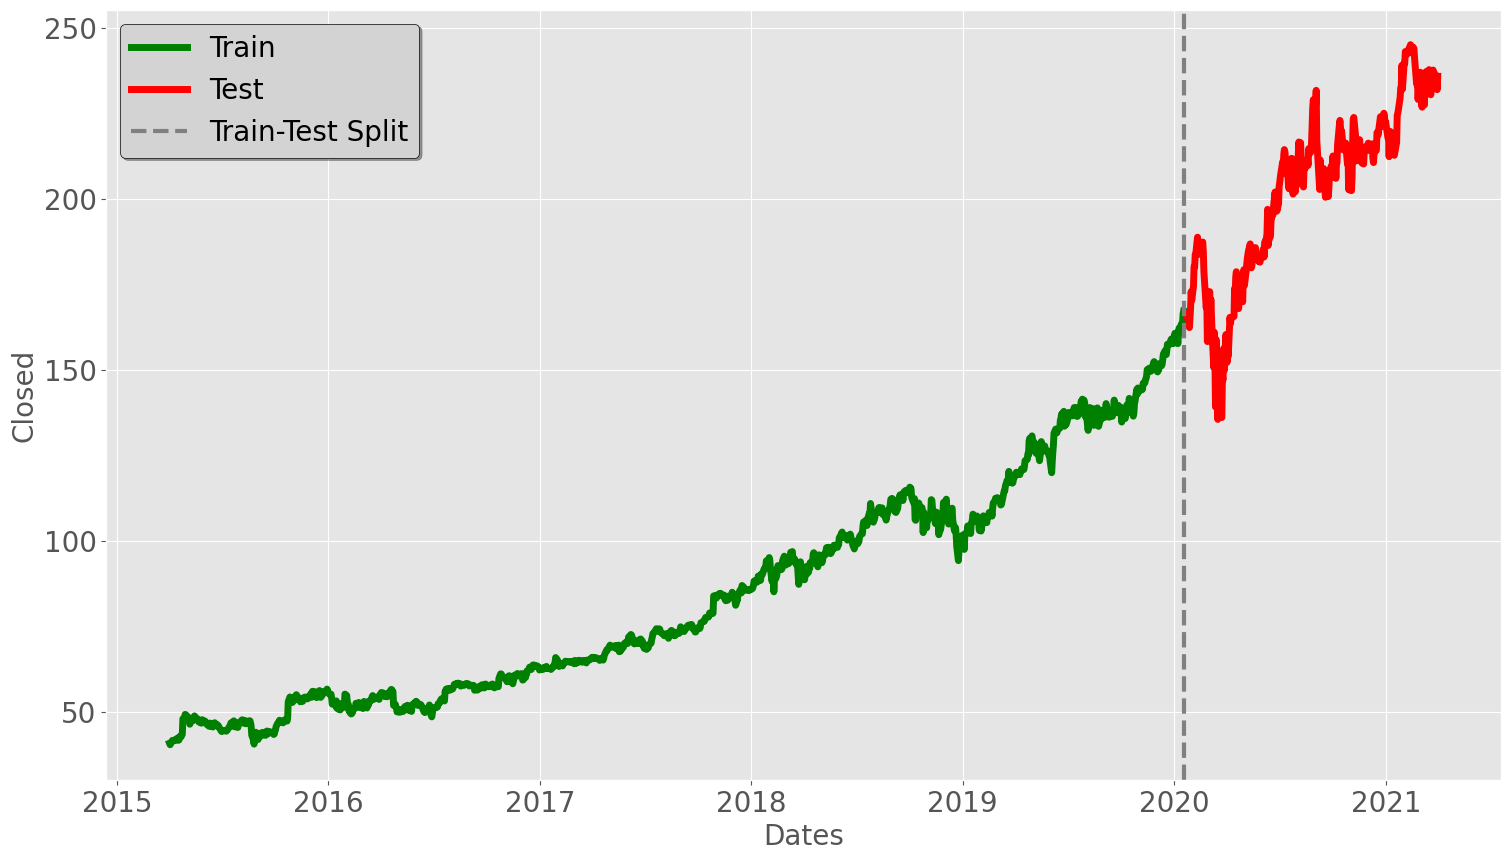

In [19]:
split_date = train_data.index[-1]

plt.figure(figsize=(18,10))
plt.grid(True)
plt.xlabel('Dates', fontsize=20)
plt.ylabel('Closed', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(train_data, 'green', label="Train",linewidth=5)
plt.plot(test_data, 'red', label='Test', linewidth=5)
plt.axvline(x=split_date, color='grey', linestyle='--', linewidth=3, label='Train-Test Split')
plt.legend(fontsize=20, shadow=True, facecolor='lightgrey', edgecolor='k')

<Figure size 1000x500 with 0 Axes>

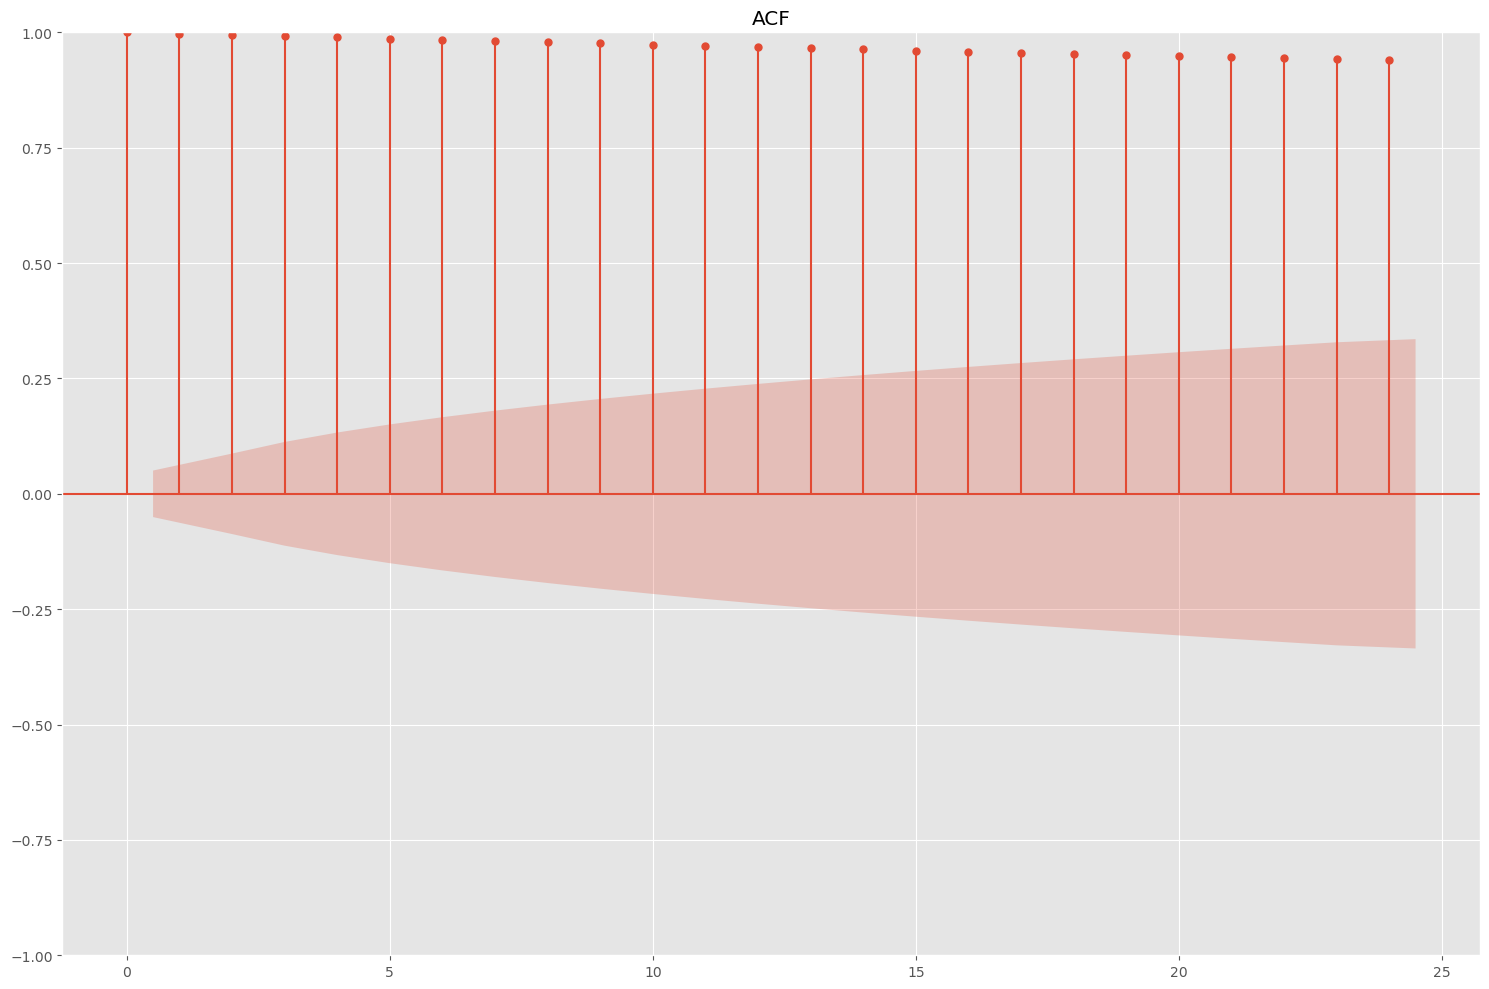

In [20]:
# Display the autocorrelation plot 
plt.figure(figsize=(10,5))
fig = tsaplots.plot_acf(time_data, lags=24)
fig.set_size_inches(15,10)
plt.title('ACF')
plt.tight_layout()

<Figure size 1000x500 with 0 Axes>

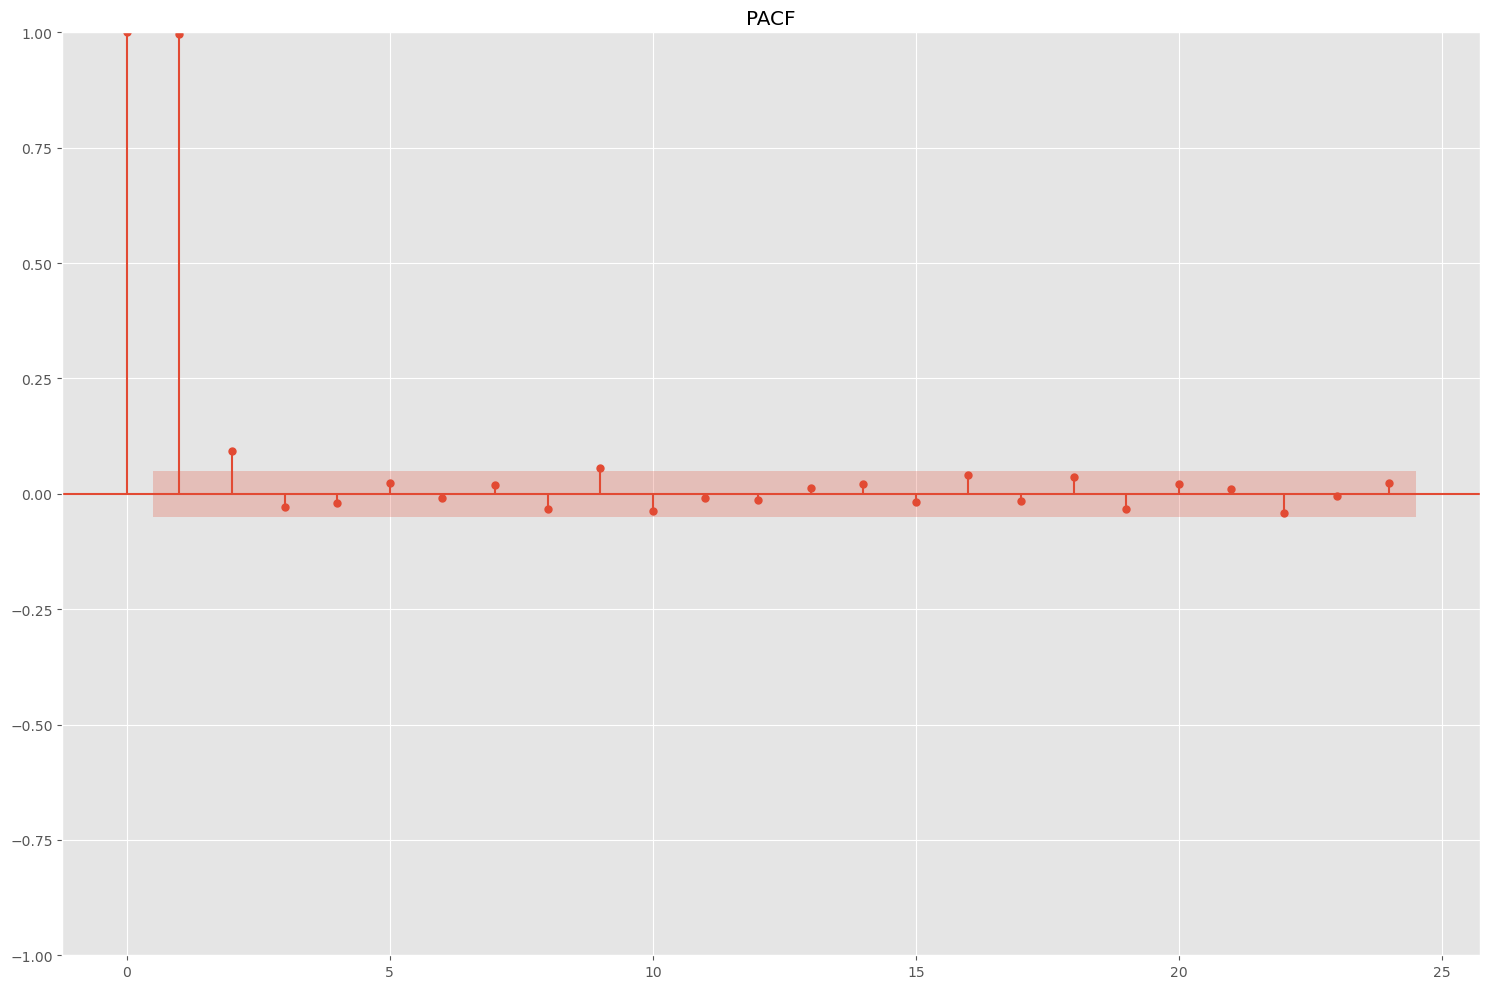

In [21]:
# Display the partial autocorrelation plot 
plt.figure(figsize=(10,5))
fig = tsaplots.plot_pacf(time_data, lags=24)
fig.set_size_inches(15,10)
plt.title('PACF')
plt.tight_layout()

# prediction with XGBoost regression

In [22]:
# preprocessing function

def preprocess_timeseries(df):
    data = df.copy()
    data = data.reset_index()
    data['year'] = data['Date'].dt.year
    data['month'] = data['Date'].dt.month
    data['day'] = data['Date'].dt.day
    data['day_of_week'] = data['Date'].dt.day_of_week
    data = data.drop(columns=['Date'])
    return data

In [23]:
train_df = preprocess_timeseries(train_data)
test_df = preprocess_timeseries(test_data)

features = ['year', 'month', 'day', 'day_of_week']
target = 'Close'

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1209, 4)
(1209,)
(302, 4)
(302,)


In [24]:
# creating a model

reg = xgb.XGBRegressor(base_score=0.5, 
                       booster='gbtree', #drop this to proceed with linear
                       n_estimators=5000,
                       early_stopping_rounds=50, #testing this
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01) #testing lr
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

[0]	validation_0-rmse:88.48437	validation_1-rmse:201.94851


[50]	validation_0-rmse:53.98834	validation_1-rmse:151.80391


c:\Users\Oleh\.conda\envs\env001\lib\site-packages\xgboost\core.py:160: UserWarning: [01:01:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:33.14285	validation_1-rmse:115.65095
[150]	validation_0-rmse:20.55665	validation_1-rmse:91.40696
[200]	validation_0-rmse:12.93690	validation_1-rmse:74.96306
[250]	validation_0-rmse:8.26186	validation_1-rmse:64.37645
[300]	validation_0-rmse:5.51822	validation_1-rmse:57.71938
[350]	validation_0-rmse:3.97849	validation_1-rmse:53.75316
[400]	validation_0-rmse:3.14472	validation_1-rmse:51.53158
[450]	validation_0-rmse:2.70110	validation_1-rmse:50.03223
[500]	validation_0-rmse:2.47373	validation_1-rmse:48.78559
[550]	validation_0-rmse:2.34931	validation_1-rmse:47.99695
[600]	validation_0-rmse:2.27203	validation_1-rmse:47.43176
[650]	validation_0-rmse:2.21390	validation_1-rmse:46.93869
[700]	validation_0-rmse:2.17005	validation_1-rmse:46.53687
[750]	validation_0-rmse:2.14404	validation_1-rmse:46.20770
[800]	validation_0-rmse:2.12128	validation_1-rmse:46.00964
[850]	validation_0-rmse:2.10509	validation_1-rmse:45.86632
[900]	validation_0-rmse:2.09089	validation_1-rmse:45

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=5000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

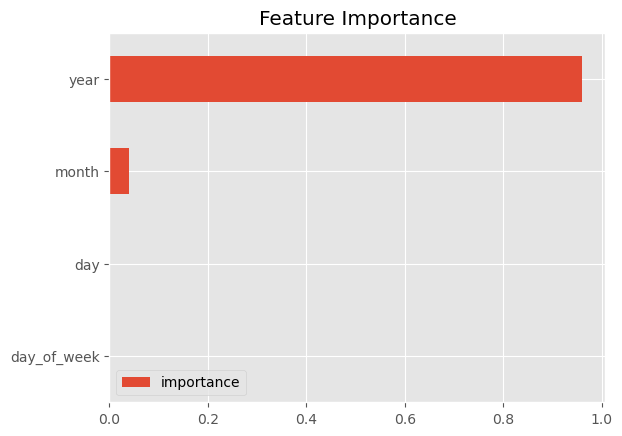

In [25]:
# checking features importance

fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [26]:
# day and DOW - seems not predictable noise for the model

# Predicting and comparing

C:\Users\Oleh\AppData\Local\Temp\ipykernel_7980\3765169695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['prediction'] = reg.predict(X_test)


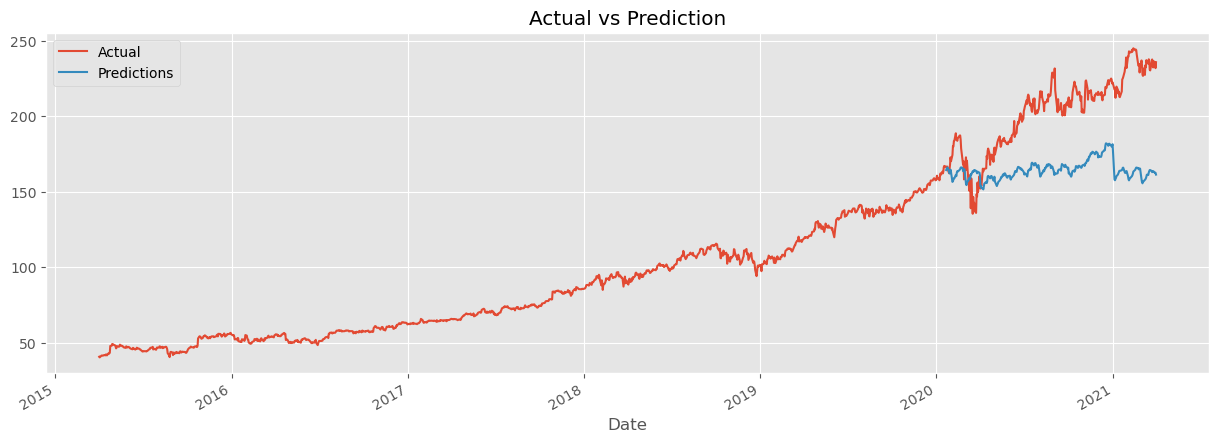

In [27]:
test_data['prediction'] = reg.predict(X_test)
df_2 = time_data.merge(test_data[['prediction']], how='left', left_index=True, right_index=True)
ax = df_2[['Close']].plot(figsize=(15, 5))
df_2['prediction'].plot(ax=ax, style='-')
plt.legend(['Actual', 'Predictions'])
ax.set_title('Actual vs Prediction')
plt.show()

In [28]:
# scores

score = np.sqrt(mean_squared_error(test_data['Close'], test_data['prediction']))
print(f'RMSE Score - test data: {score:0.2f}')

RMSE Score - test data: 44.91
